# PIPELINE - ANALISIS CONSUMO ELECTRICO SUBESTACIONES ZONA CENTRAL CHILE
Jose Eduardo Montalba Gomez

In [2]:
# Importar las librerías necesarias para el análisis de series temporales

import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


# Conjunto de datos

## Conjunto de datos: train

In [4]:
data=pd.read_csv("train.csv",sep=",")
data["date"]=pd.to_datetime(data["date"])
data_exogen = data.copy()
data=data.set_index("date")
data.head()
data

,substation,consumption
date,,
2018-01-01 00:00:00,AJAHUEL,137.330840
2018-01-01 01:00:00,AJAHUEL,124.045549
2018-01-01 02:00:00,AJAHUEL,118.137811
2018-01-01 03:00:00,AJAHUEL,107.899499
2018-01-01 04:00:00,AJAHUEL,100.362069
...,...,...
2021-12-31 19:00:00,LOSALME,168.644175
2021-12-31 20:00:00,LOSALME,171.593959
2021-12-31 21:00:00,LOSALME,160.167061


In [5]:
# Descripción de los datos de entrenamiento
data.describe()

,consumption
count,244391.000000
mean,179.548024
std,156.018729
min,-199.000000
25%,0.181926
50%,172.099977
75%,262.179646
max,752.006309


<class 'pandas.core.series.Series'>
DatetimeIndex: 35064 entries, 2018-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: h
Series name: consumption
Non-Null Count  Dtype  
--------------  -----  
35064 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


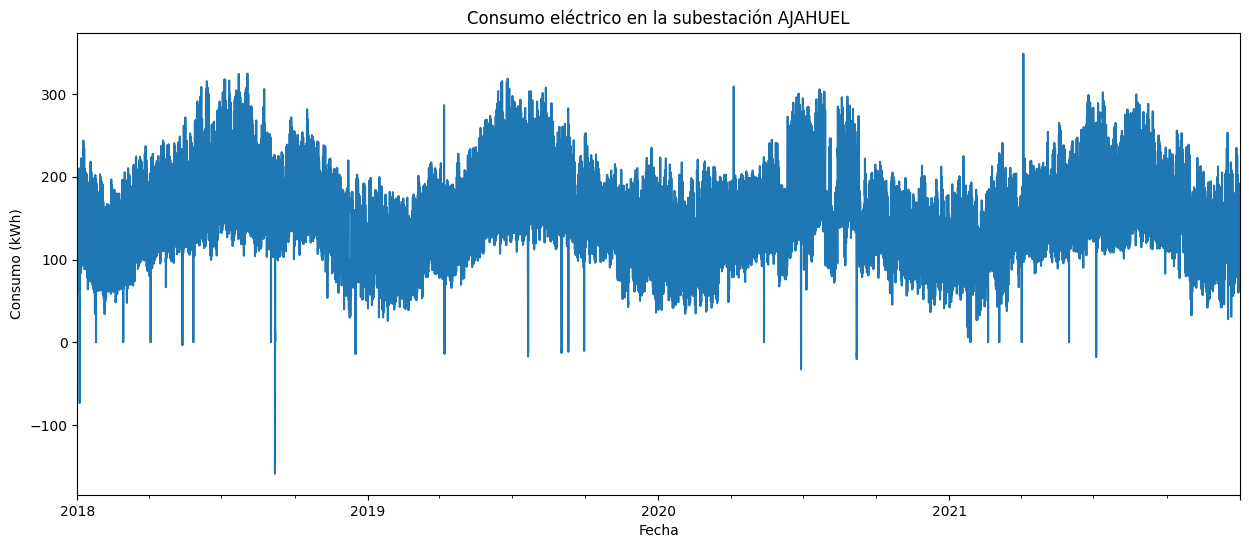

In [6]:
# Cambia aquí el nombre de la subestación que quieres analizar
substation_name = "AJAHUEL"  

# Separamos el dataset en las distintas subestaciones eléctricas
# hacemos un resample a datos horarios
# una interpolación lineal para completar los datos faltantes
data_substation = data['consumption'][data['substation'] == substation_name]
data_substation = data_substation.resample('h').interpolate()
data_exogen_substation = data_exogen[data_exogen['substation'] == substation_name].copy()


# Descripción y visualización de los datos de la subestación seleccionada
data_substation.info()
data_substation.describe()
data_substation.plot(figsize=(15, 6))
plt.title(f'Consumo eléctrico en la subestación {substation_name}')
plt.ylabel('Consumo (kWh)')
plt.xlabel('Fecha')
plt.show()

In [7]:
# Revisamos si el dataset tiene valores nulos o NaN (Not a Number) 
print("Datos NaN:", len(data_substation[data_substation.isna()==True]),"- Datos Nulos:", len(data_substation[data_substation.isnull() == True]))


Datos NaN: 0 - Datos Nulos: 0


In [8]:
# Calcular el rango intercuartílico (IQR) para detectar outliers
Q1 = data_substation.quantile(0.25)
Q3 = data_substation.quantile(0.75)
IQR = Q3 - Q1

# Definir los límites de detección de outliers (rango intercuartil)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers
outliers = (data_substation < lower_bound) | (data_substation > upper_bound)

mean_data_substation = data_substation.mean()

if data_substation[outliers].count():
    data_substation[outliers] = mean_data_substation


## Análisis conjunto de datos: train

C:\Users\JEM\AppData\Local\Temp\ipykernel_9244\2338106363.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45);


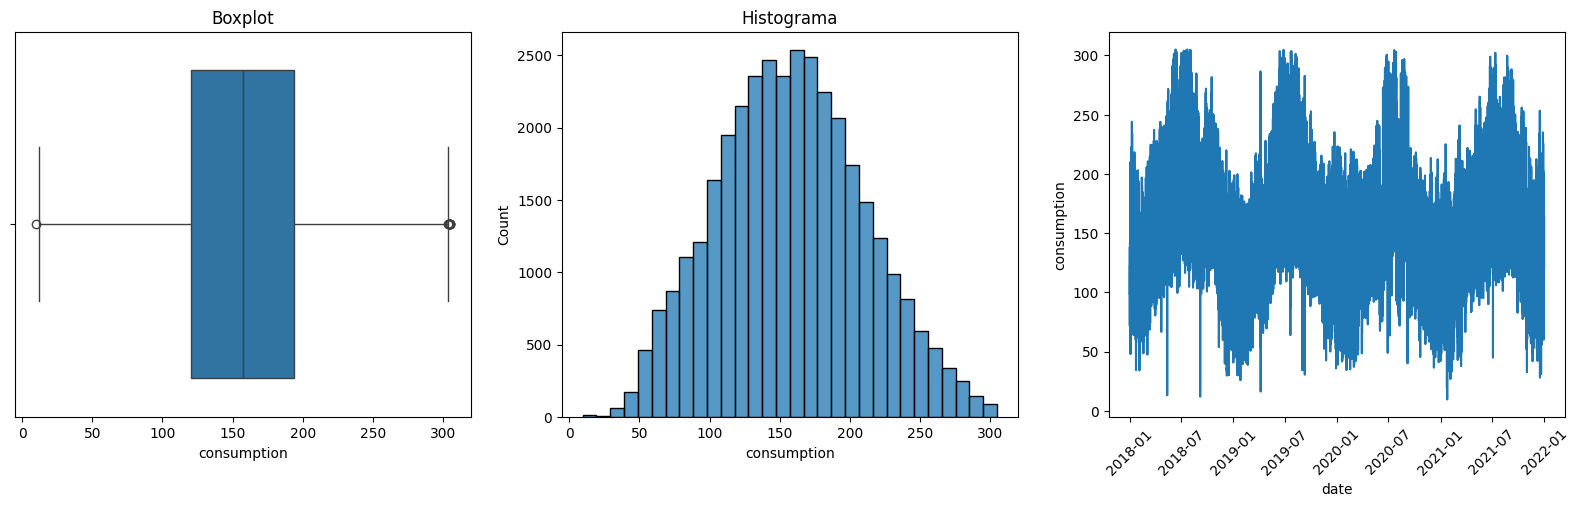

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
x_analisis = data_substation[:]
fig, axes=plt.subplots(1,3)
fig.set_size_inches(20,5)

axes[0].set_title('Boxplot')
sns.boxplot(ax=axes[0], x=x_analisis)

axes[1].set_title('Histograma')
sns.histplot(ax=axes[1], x=x_analisis,  bins=30)


my_plot = sns.lineplot(ax=axes[2], y = x_analisis, x=x_analisis.index);
# — rotate x-axis labels
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45);

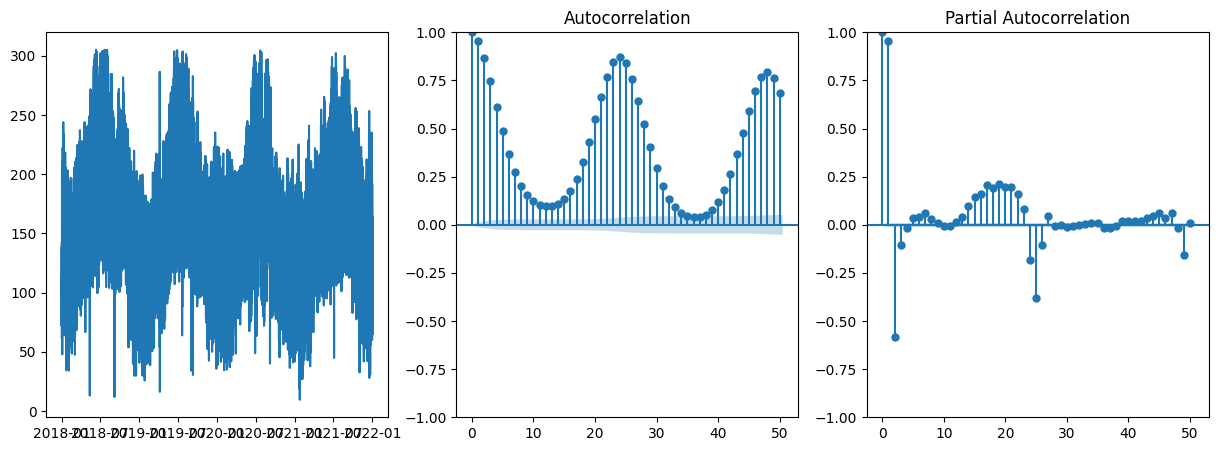

In [10]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 

fig, axes=plt.subplots(1,3)
fig.set_size_inches(15,5)
axes[0].plot(data_substation.index,data_substation)
plot_acf(data_substation,lags=50,ax=axes[1]);
plot_pacf(data_substation,lags=50,ax=axes[2]);

<Axes: xlabel='y(t)', ylabel='y(t + 48)'>

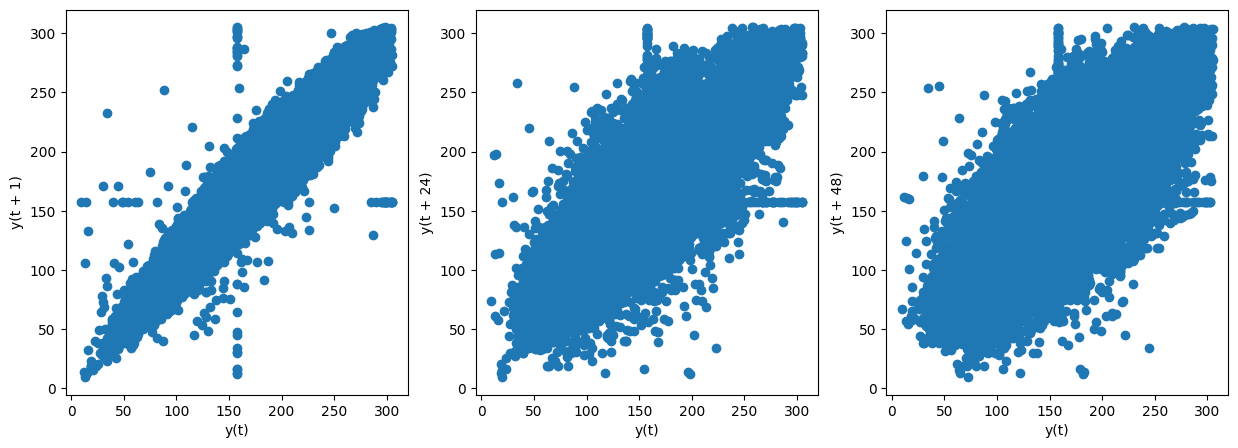

In [11]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15, 5)
pd.plotting.lag_plot(data_substation, lag=1,ax=axes[0])
pd.plotting.lag_plot(data_substation, lag=24,ax=axes[1])
pd.plotting.lag_plot(data_substation, lag=48,ax=axes[2])

14.430184369224554


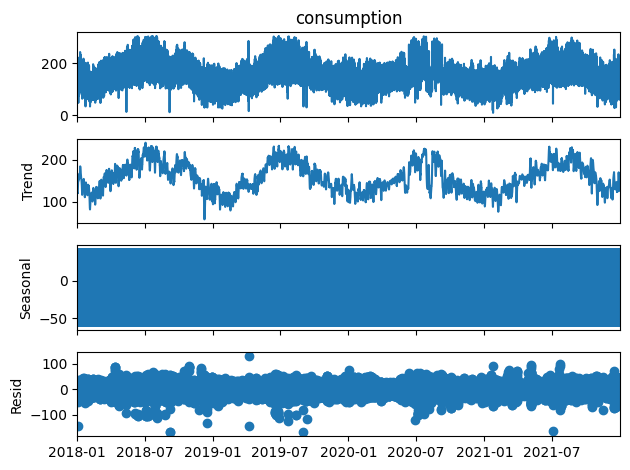

In [12]:
result=seasonal_decompose(data_substation,model="additive",period=48);
promedio_abs_error = abs(result.resid).mean();
result.plot();
print(promedio_abs_error)

In [13]:
# Revisamos mediante el conjunto de train adfuller si nuestros Conjunto de datos son estacionarios.
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_substation,maxlag=1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -54.020093
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


## Conjunto de datos: test

In [14]:
# Cargar el conjunto de prueba 
data_test=pd.read_csv("test.csv",sep=",")
data_test["date"]=pd.to_datetime(data_test["date"])
data_test=data_test.set_index("date")
data_test.head()

,substation,consumption
date,,
2022-01-01 00:00:00,AJAHUEL,102.093131
2022-01-01 01:00:00,AJAHUEL,82.379086
2022-01-01 02:00:00,AJAHUEL,75.126780
2022-01-01 03:00:00,AJAHUEL,69.140084
2022-01-01 04:00:00,AJAHUEL,66.442176


In [15]:
# Mostramos la información del conjunto de prueba
data_test.info()
data_test.describe()
data_test.head()   

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61313 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   substation   61313 non-null  object 
 1   consumption  61313 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.4+ MB


,substation,consumption
date,,
2022-01-01 00:00:00,AJAHUEL,102.093131
2022-01-01 01:00:00,AJAHUEL,82.379086
2022-01-01 02:00:00,AJAHUEL,75.126780
2022-01-01 03:00:00,AJAHUEL,69.140084
2022-01-01 04:00:00,AJAHUEL,66.442176


<class 'pandas.core.series.Series'>
DatetimeIndex: 8760 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Freq: h
Series name: consumption
Non-Null Count  Dtype  
--------------  -----  
8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


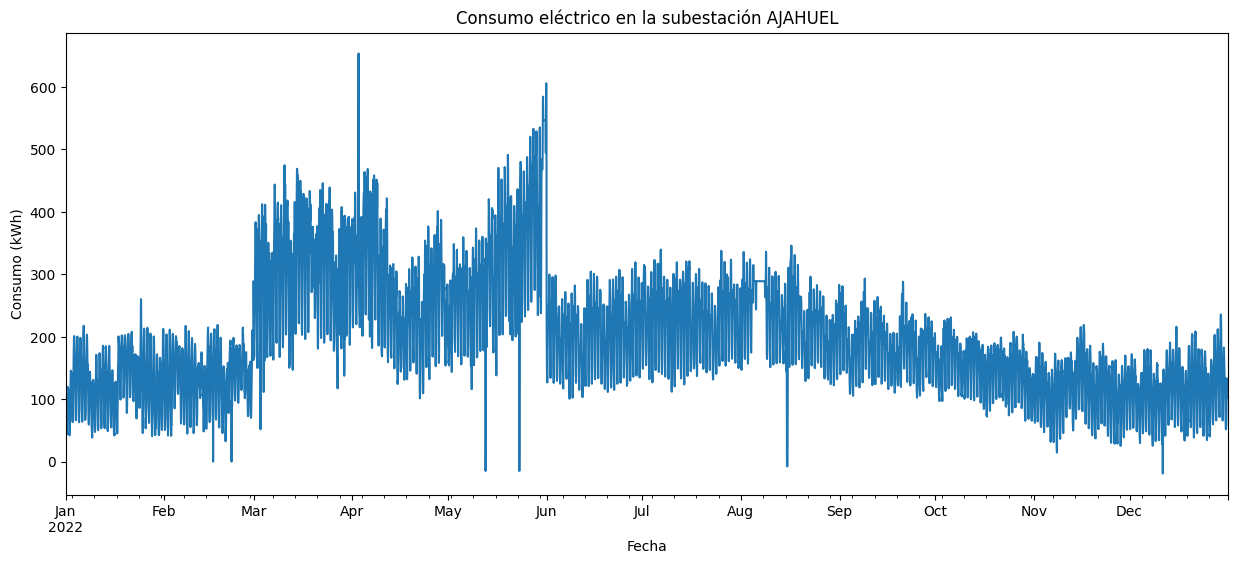

In [16]:
# Cambia aquí el nombre de la subestación que quieres analizar
substation_name = "AJAHUEL"  

# Separamos el dataset en la subestación eléctrica seleccionada
# hacemos un resample a datos horarios
# una interpolación lineal para completar los datos faltantes
data_test_substation = data_test['consumption'][data_test['substation'] == substation_name]
data_test_substation = data_test_substation.resample('h').interpolate()


# Descripción y visualización de los datos de la subestación seleccionada
data_test_substation.info()
data_test_substation.describe()
data_test_substation.plot(figsize=(15, 6))
plt.title(f'Consumo eléctrico en la subestación {substation_name}')
plt.ylabel('Consumo (kWh)')
plt.xlabel('Fecha')
plt.show()


# Código

## -- SARIMA

### --- SARIMA 24 horas

In [20]:
# — Ajustamos el Arquitectura del modelo SARIMA con una ventana de 24

sarima_model_24 = SARIMAX(endog=data_substation, order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
sarima_result_24 = sarima_model_24.fit(disp=False)

In [21]:
# — sarima_model_24=[]
# — sarima_result_24 = []


In [23]:
# — Predecir los valores con SARIMA
sarima_pred_train_24 = sarima_result_24.predict(start=0, end=len(data_substation)-1, typ='levels')

In [24]:
# — Predecir también para el conjunto de test
sarima_pred_test_24 = sarima_result_24.predict(start=len(data_substation), end=len(data_substation) + len(data_test_substation) - 1)

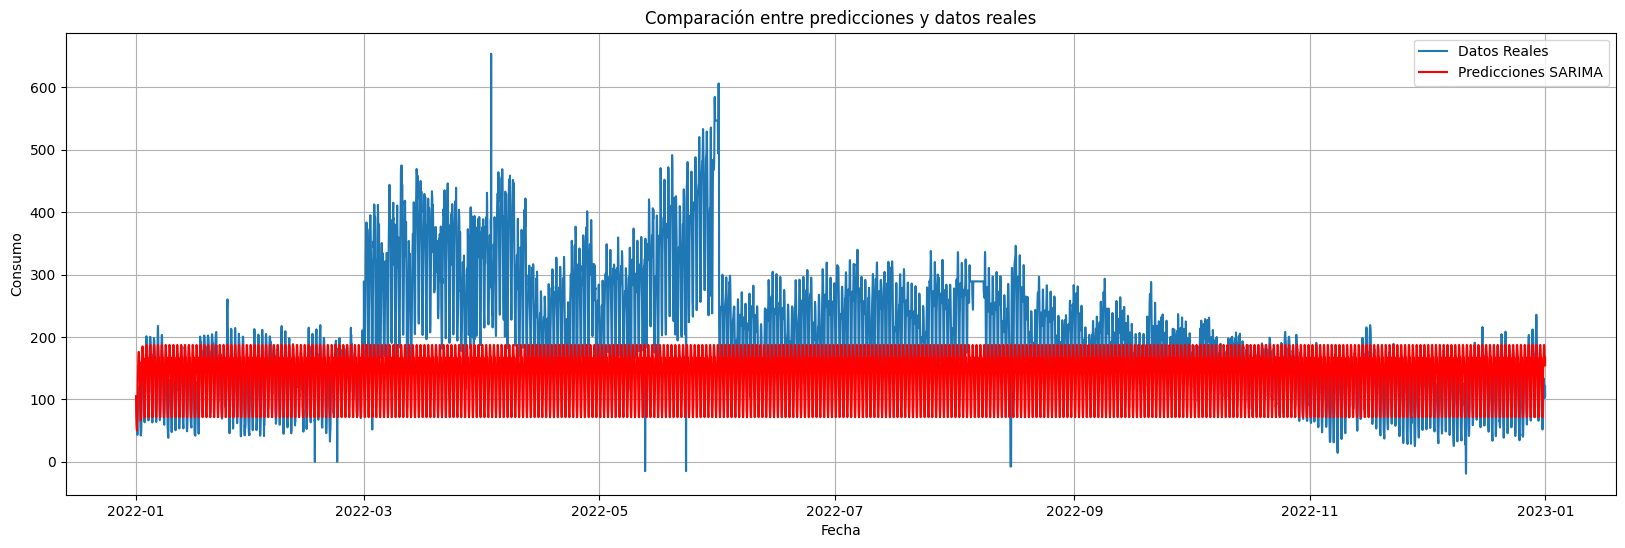

Mean Squared Error (MSE): 11043.545975323932
Root Mean Squared Error (RMSE): 105.08827705945099
Mean Absolute Error (MAE): 77.13974456471298
Mean Absolute Percentage Error (MAPE): 90571525094652.42
R-squared (R2): -0.25488797929935525


In [26]:
plt.figure(figsize=(20, 6))
plt.plot(data_test_substation.index,data_test_substation, label='Datos Reales')
plt.plot(sarima_pred_test_24.index, sarima_pred_test_24, label='Predicciones SARIMA', color='red')
plt.title('Comparación entre predicciones y datos reales')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

# — Calcula las métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse_sarima_24 = mean_squared_error(data_test_substation, sarima_pred_test_24)
rmse_sarima_24 = np.sqrt(mse_sarima_24)
mae_sarima_24 = mean_absolute_error(data_test_substation, sarima_pred_test_24)
mape_sarima_24 = mean_absolute_percentage_error(data_test_substation, sarima_pred_test_24)
r2_sarima24 = r2_score(data_test_substation[:50], sarima_pred_test_24[:50])

print(f"Mean Squared Error (MSE): {mse_sarima_24}")
print(f"Root Mean Squared Error (RMSE): {rmse_sarima_24}")
print(f"Mean Absolute Error (MAE): {mae_sarima_24}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sarima_24}")
print(f"R-squared (R2): {r2_sarima24}")

### --- SARIMA con Conjunto de datos exogenos

In [27]:
# — data_AJAHUEL_exogen=data_AJAHUEL.copy()
data_exogen_substation['year'] = data_exogen_substation['date'].dt.year
data_exogen_substation['quarter'] = data_exogen_substation['date'].dt.quarter
data_exogen_substation['month'] = data_exogen_substation['date'].dt.month
data_exogen_substation['day'] = data_exogen_substation['date'].dt.day
data_exogen_substation['hour'] = data_exogen_substation['date'].dt.hour
data_exogen_substation['day_of_week'] = data_exogen_substation['date'].dt.dayofweek
data_exogen_substation['day_of_year'] = data_exogen_substation['date'].dt.dayofyear

In [29]:

import numpy as np
# Aplicar funciones seno y coseno para las variables cíclicas (hora y día de la semana)
data_exogen_substation['hour_sin'] = np.sin(2 * np.pi * data_exogen_substation['hour'] / 24)
data_exogen_substation['hour_cos'] = np.cos(2 * np.pi * data_exogen_substation['hour'] / 24)

data_exogen_substation['day_of_week_sin'] = np.sin(2 * np.pi * data_exogen_substation['day_of_week'] / 7)
data_exogen_substation['day_of_week_cos'] = np.cos(2 * np.pi * data_exogen_substation['day_of_week'] / 7)

# Ciclos trimestrales
data_exogen_substation['quarter_sin'] = np.sin(2 * np.pi * data_exogen_substation['quarter'] / 4)
data_exogen_substation['quarter_cos'] = np.cos(2 * np.pi * data_exogen_substation['quarter'] / 4)

# Ciclos mensuales

data_exogen_substation['month_sin'] = np.sin(2 * np.pi * data_exogen_substation['month'] / 12)
data_exogen_substation['month_cos'] = np.cos(2 * np.pi * data_exogen_substation['month'] / 12)

# Ciclos anuales
data_exogen_substation['year_sin'] = np.sin(2 * np.pi * data_exogen_substation['day_of_year'] / 365)
data_exogen_substation['year_cos'] = np.cos(2 * np.pi * data_exogen_substation['day_of_year'] / 365)

# Mostramos el dataframe con las nuevas características
data_exogen_substation


,substation,date,consumption,year,quarter,month,day,hour,day_of_week,day_of_year,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,quarter_sin,quarter_cos,month_sin,month_cos,year_sin,year_cos
0,AJAHUEL,2018-01-01 00:00:00,137.330840,2018,1,1,1,0,0,1,0.000000,1.000000,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
1,AJAHUEL,2018-01-01 01:00:00,124.045549,2018,1,1,1,1,0,1,0.258819,0.965926,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
2,AJAHUEL,2018-01-01 02:00:00,118.137811,2018,1,1,1,2,0,1,0.500000,0.866025,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
3,AJAHUEL,2018-01-01 03:00:00,107.899499,2018,1,1,1,3,0,1,0.707107,0.707107,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
4,AJAHUEL,2018-01-01 04:00:00,100.362069,2018,1,1,1,4,0,1,0.866025,0.500000,0.000000,1.000000,1.000000e+00,6.123234e-17,5.000000e-01,0.866025,1.721336e-02,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34908,AJAHUEL,2021-12-31 19:00:00,157.753424,2021,4,12,31,19,4,365,-0.965926,0.258819,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000
34909,AJAHUEL,2021-12-31 20:00:00,132.997811,2021,4,12,31,20,4,365,-0.866025,0.500000,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000
34910,AJAHUEL,2021-12-31 21:00:00,132.565346,2021,4,12,31,21,4,365,-0.707107,0.707107,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000
34911,AJAHUEL,2021-12-31 22:00:00,140.933730,2021,4,12,31,22,4,365,-0.500000,0.866025,-0.433884,-0.900969,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000,6.432491e-16,1.000000


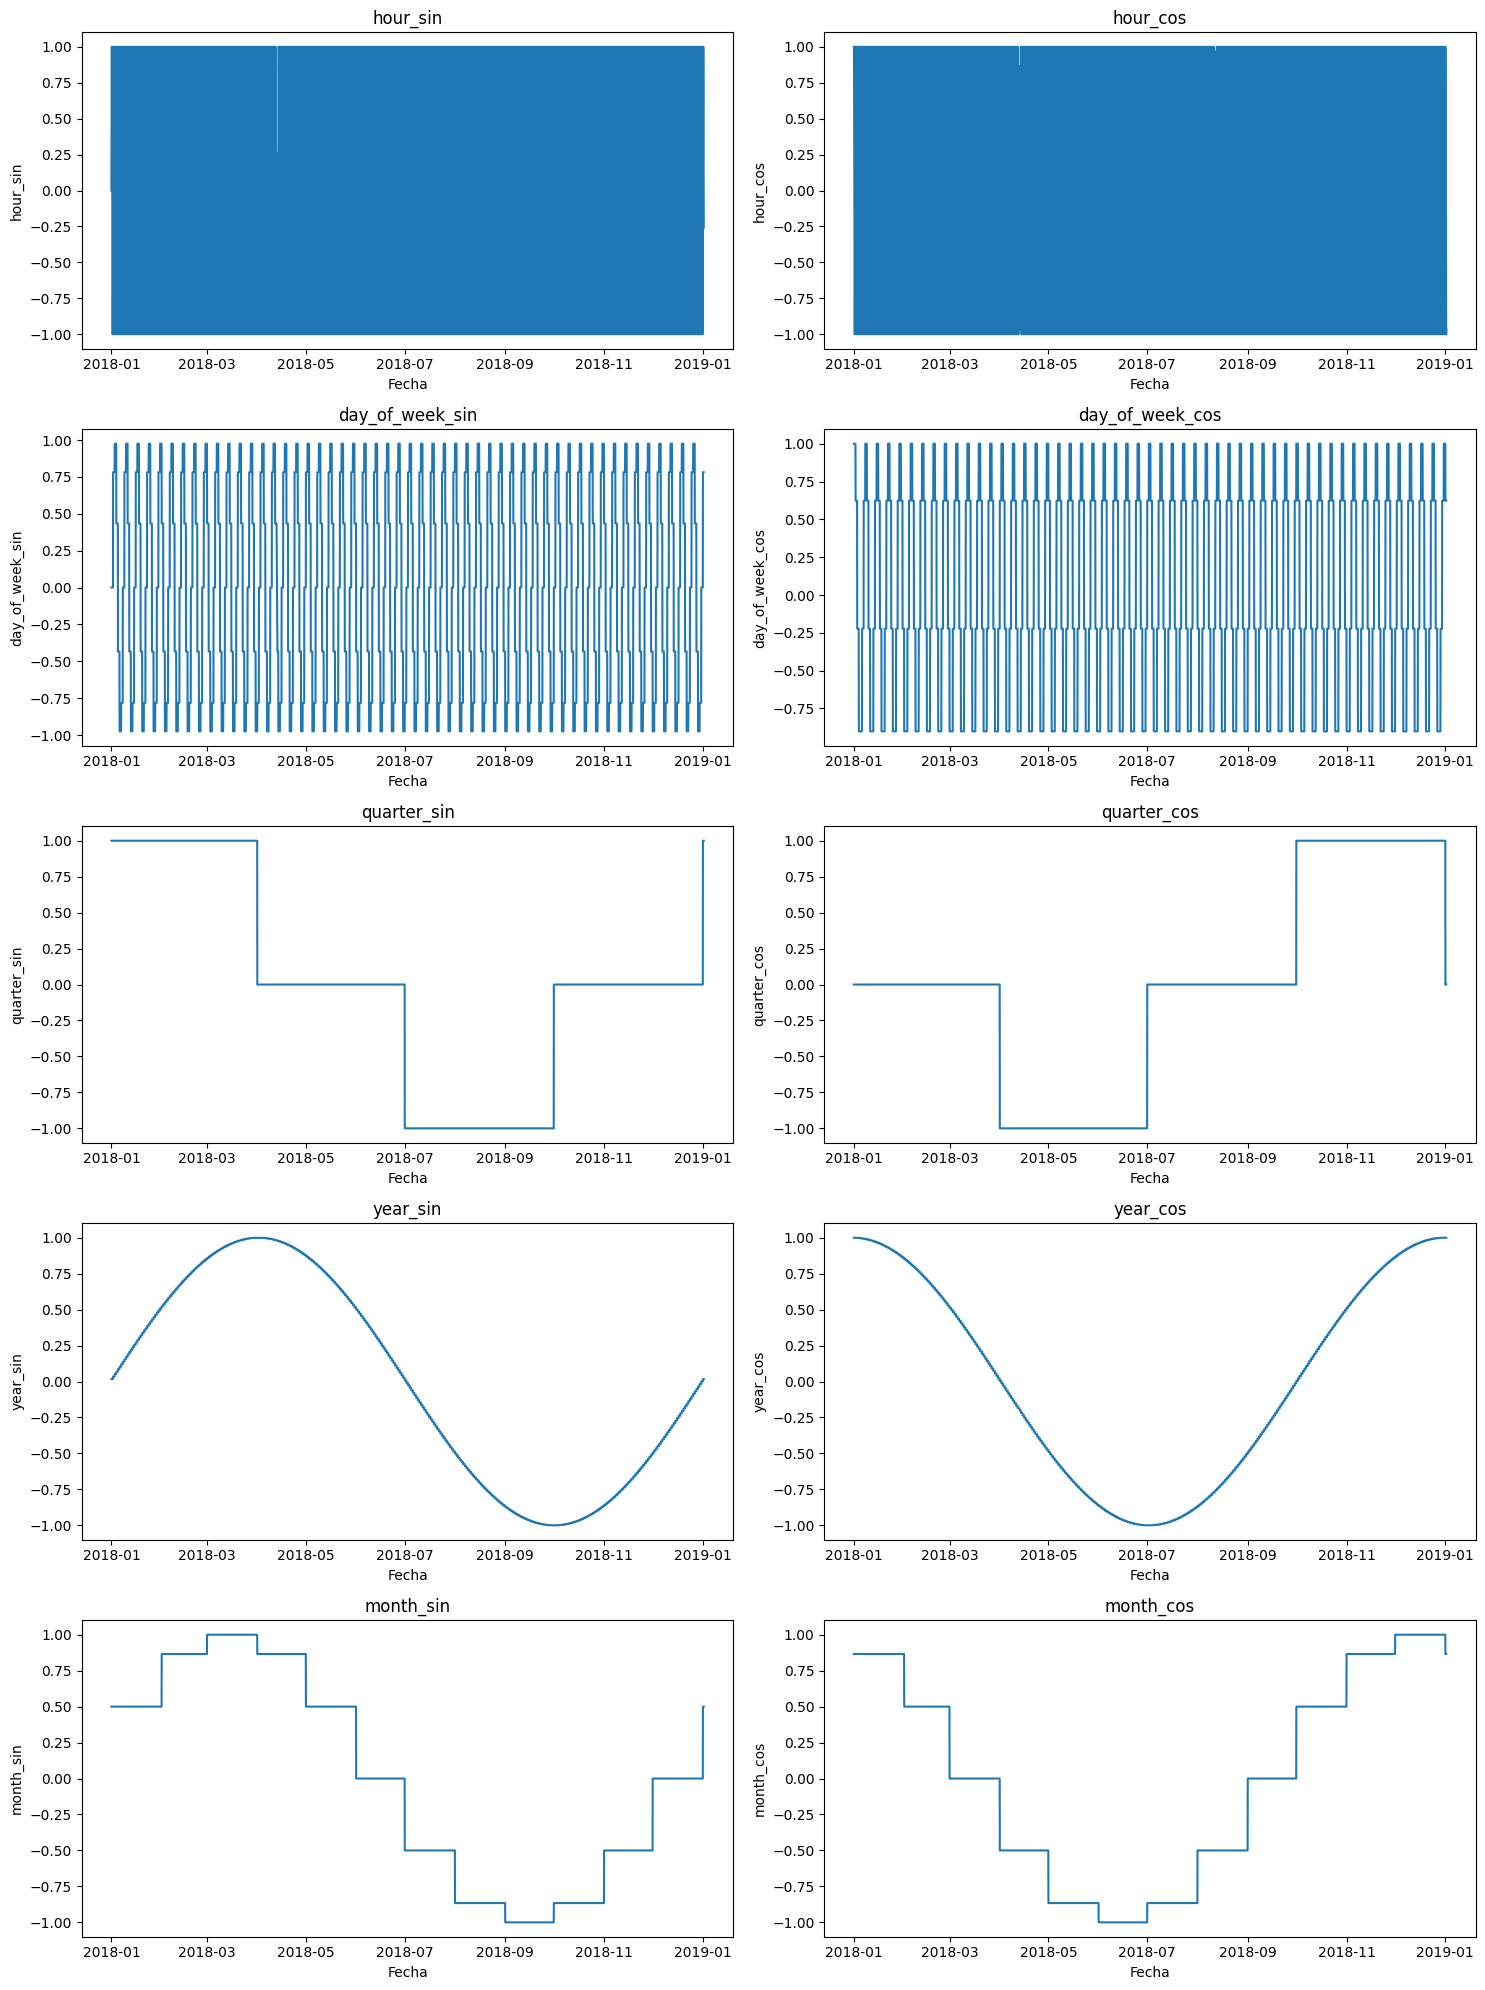

In [30]:
# — Crear una figura con 2 subplots de ancho
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

# — Lista de columnas a graficar
columnas = ['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin', 'quarter_cos', 'year_sin', 'year_cos',  'month_sin', 'month_cos']

# — Iterar sobre las columnas y generar los subplots
for i, columna in enumerate(columnas):
  row = i // 2
  col = i % 2
  axes[row, col].plot(data_exogen_substation['date'][:8760], data_exogen_substation[columna][:8760])
  axes[row, col].set_title(columna)
  axes[row, col].set_xlabel('Fecha')
  axes[row, col].set_ylabel(columna)

# — Ajustar el espaciado entre los subplots
plt.tight_layout()

# — Mostrar la figura
plt.show()


In [31]:
# Definimos las variables endógenas (consumo) y exógenas (características cíclicas)
endog = data_exogen_substation['consumption']

exog = data_exogen_substation[['hour_sin','hour_cos','day_of_week_sin','day_of_week_cos', 'year_sin', 'year_cos']]

exog2 = data_exogen_substation[['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin', 'quarter_cos', 'year_sin', 'year_cos']]

In [32]:
# Creamos el Arquitectura del modelo SARIMAX (ajusta el orden según tus Conjunto de datos)
modelo_prediccion = sm.tsa.SARIMAX(endog, exog=exog, order=(1, 0, 1), seasonal_order=(1, 1, 1, 24))
resultados_modelo = modelo_prediccion.fit()

C:\Users\JEM\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [253]:
# — modelo_prediccion = []
# — resultados_modelo = []


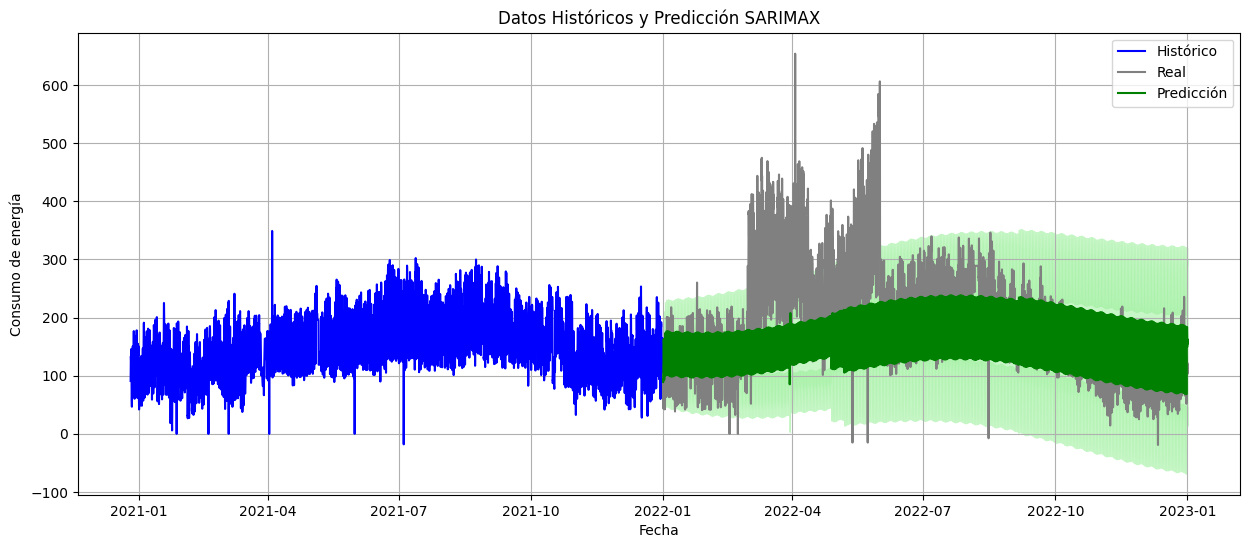

Mean Squared Error (MSE): 8357.772404909532
Root Mean Squared Error (RMSE): 91.42085322785788
Mean Absolute Error (MAE): 62.6880508959643
R-squared (R2): 0.050245498476356176


In [ ]:
# Pronóstico: desde el final de los Conjunto de datos históricos hasta 24 pasos en el futuro
n_steps = len(data_test_substation)  # Cambia este valor según cuántos pasos en el futuro deseas predecir
pred = resultados_modelo.get_forecast(steps=n_steps, exog=exog.iloc[-n_steps:])

# Obtenemos los intervalos de confianza para las predicciones
pred_ci = pred.conf_int()

# Graficamos los Conjunto de datos históricos
plt.figure(figsize=(15, 6))
plt.plot(data_exogen_substation['date'][-n_steps:], data_exogen_substation['consumption'][-n_steps:], label='Histórico', color='blue')


# Graficamos los Conjunto de datos reales
plt.plot(data_test_substation.index[:n_steps], data_test_substation[:n_steps], label='Real', color='gray')

# Graficamos la Pronóstico
pred_index = pd.date_range(start=data_exogen_substation['date'].iloc[-1], periods=n_steps+1, freq='h')[1:]
plt.plot(pred_index, pred.predicted_mean, label='Predicción', color='green')

# Graficamos los intervalos de confianza
plt.fill_between(pred_index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='lightgreen', alpha=0.5)

# Etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Consumo de energía')
plt.title('Datos Históricos y Predicción Modelo SARIMAX')
plt.legend()

# Mostrar Visualización(es)
plt.grid(True)
plt.show()

# Métricas y evaluación

mse = mean_squared_error(data_test_substation[:n_steps], pred.predicted_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(data_test_substation[:n_steps], pred.predicted_mean)
mape = mean_absolute_percentage_error(data_test_substation[:n_steps], pred.predicted_mean)
r2 = r2_score(data_test_substation[:n_steps], pred.predicted_mean)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
# — print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R-squared (R2): {r2}")


### --- LSTM

In [70]:
# — Preprocesar los Conjunto de datos

# — Normalizar los Conjunto de datos para que estén en el rango [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# — Aplicamos el escalador al conjunto de Ajuste del modelo
data_substation_scaled = scaler.fit_transform(data_substation.values.reshape(-1, 1))

# — Aplicamos el escalador al conjunto de conjunto_prueba
data_test_substation_scaled = scaler.transform(data_test_substation.values.reshape(-1, 1))


In [71]:
# — Convertir los Conjunto de datos a secuencias que LSTM pueda entender
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# — Crear secuencias para Ajuste del modelo (24 horas de historial)
time_steps = 24
X_train, y_train = create_sequences(data_substation_scaled, time_steps)

# — Crear secuencias para conjunto test
X_test, y_test = create_sequences(data_test_substation_scaled, time_steps)

# — Reshape para que sea compatible con LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [78]:
import keras_tuner as kt
#import tensorflow as tf
#from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [79]:
# — Definir la función de construcción del Arquitectura del modelo LSTM con Keras Tuner
def build_model(hp):
    modelo_prediccion = Sequential()
    
    # — Capa de entrada
    modelo_prediccion.add(Input(shape=(time_steps, 1)))
    
    # — Capas LSTM con Parámetro(s) ajustables
    for i in range(hp.Int('num_layers', 1, 3)):  # Ajustar entre 1 y 3 capas LSTM
        modelo_prediccion.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                       return_sequences=(i < hp.Int('num_layers', 1, 3) - 1)))
        modelo_prediccion.add(Dropout(rate=hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
        # — Capa de salida
    modelo_prediccion.add(Dense(1))
    
    # — Compilación del Arquitectura del modelo
    modelo_prediccion.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error')
    
    return modelo_prediccion



In [82]:
import os
from pathlib import Path
import keras_tuner as kt

# 1) Ruta corta y absoluta (ajústala si quieres)
BASE_DIR = Path("C:/kt_runs").resolve()
BASE_DIR.mkdir(parents=True, exist_ok=True)

# 2) (Opcional) Probar permisos creando un archivo mínimo
probe = BASE_DIR / "probe"
probe.mkdir(exist_ok=True)
with open(probe / "probe.txt", "w") as f:
    f.write("ok")

# 4) Crear el tuner con overwrite y proyecto corto
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory=str(BASE_DIR),     # <= absoluta y existente
    project_name="lstm_tune",    # <= nombre corto (evita rutas largas)
    overwrite=True               # <= fuerza recreación limpia de estructura
)

## — Definir el tuner de búsqueda aleatoria
#tuner = kt.RandomSearch(
#    build_model,
#    objective='val_loss',  # Minimizar la pérdida de validación
#    max_trials=10,  # Realizar hasta 10 configuraciones diferentes
#    executions_per_trial=2,  # Ejecutar cada configuración 2 veces
#    directory='trial_LSTM_tuning',  # Guardar los resultados en este directorio
#    project_name='lstm_tuning'  # Nombre del proyecto
#)


In [83]:
# — Realizar la búsqueda
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Trial 20 Complete [00h 05m 20s]
val_loss: 0.00471143564209342

Best val_loss So Far: 0.0037936351727694273
Total elapsed time: 00h 45m 38s


In [84]:
# — Obtener el mejor Arquitectura del modelo
best_model = tuner.get_best_models(num_models=1)[0]

# — Mostrar el resumen del mejor Arquitectura del modelo
best_model.summary()

c:\Program Files\Python310\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
# — Entrenar el mejor Arquitectura del modelo con más épocas si es necesario
history_tunner = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test[:,:,:], y_test[:]), callbacks=[early_stopping])

Epoch 1/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0013 - val_loss: 0.0062
Epoch 2/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0013 - val_loss: 0.0082
Epoch 3/50
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0013 - val_loss: 0.0043


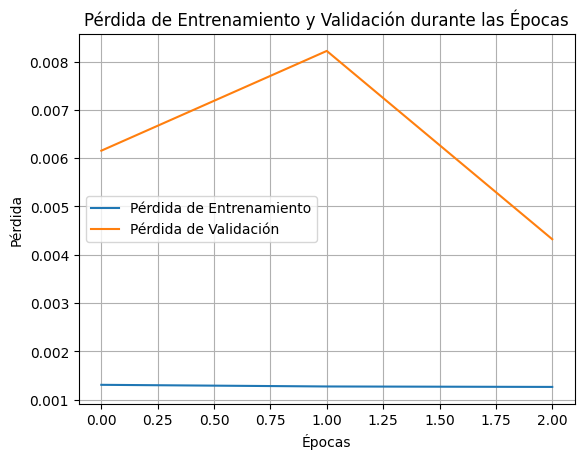

In [89]:
plt.plot(history_tunner.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history_tunner.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación durante las Épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# — 4. Evaluar el Arquitectura del modelo en los Conjunto de datos de conjunto_prueba
y_pred_scaled = best_model.predict(X_test[:])

# — Invertir la normalización de los valores predichos y reales
predicciones_y = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(reales_y[:].reshape(-1, 1))

# — Calcular el error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# — Calcula las métricas
mse_LSTM = mean_squared_error(y_test_actual, predicciones_y)
rmse_LSTM = np.sqrt(mse_LSTM)
mae_LSTM = mean_absolute_error(y_test_actual, predicciones_y)
mape_LSTM = mean_absolute_percentage_error(y_test_actual, predicciones_y)
r2_LSTM = r2_score(y_test_actual, predicciones_y)

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Mean Squared Error (MSE): 537.700420249869
Root Mean Squared Error (RMSE): 23.188368210158064
Mean Absolute Error (MAE): 11.97138420957333
R-squared (R2): 0.9388136700280729


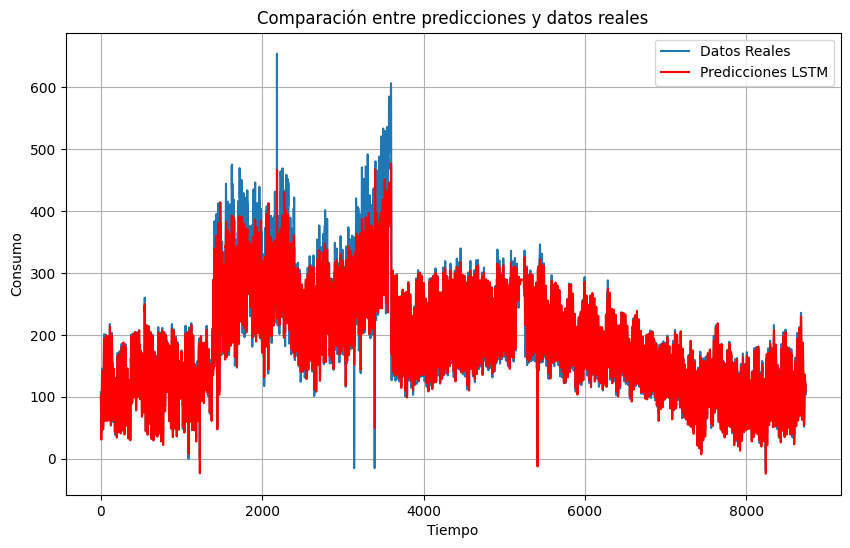

In [91]:
# — Imprime las métricas
print(f"Mean Squared Error (MSE): {mse_LSTM}")
print(f"Root Mean Squared Error (RMSE): {rmse_LSTM}")
print(f"Mean Absolute Error (MAE): {mae_LSTM}")
# — print(f"Mean Absolute Percentage Error (MAPE): {mape_LSTM}")
print(f"R-squared (R2): {r2_LSTM}")
# — Opción: Graficar los Hallazgos
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Datos Reales')
plt.plot(predicciones_y, label='Predicciones LSTM', color='red')
plt.title('Comparación entre predicciones y datos reales')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

## -- SARIMA + LSTM


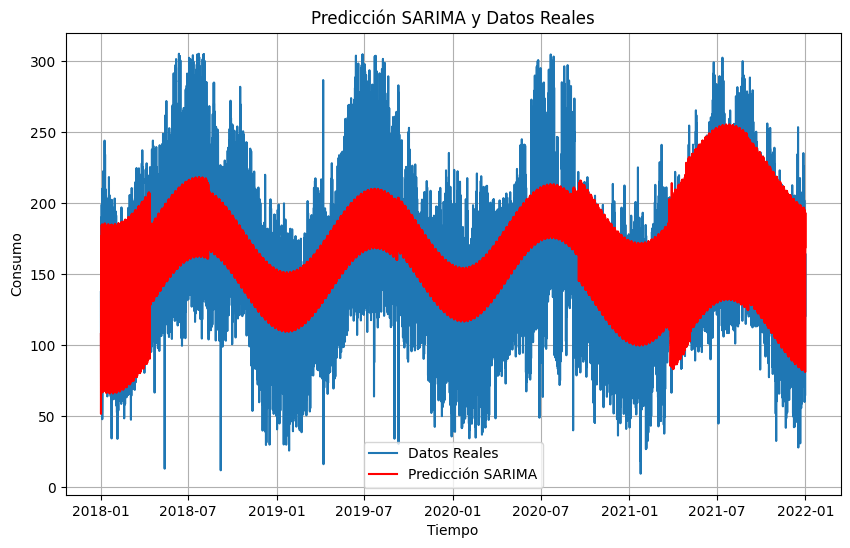

In [92]:
# — 3. Calcular los residuos (residuals) para el Ajuste del modelo

sarima_pred_train = resultados_modelo.get_forecast(steps=len(exog), exog=exog.iloc[:])

residuals_train = data_exogen_substation['consumption'] - sarima_pred_train.predicted_mean.copy().reset_index(drop=True)

# — Para visualización, graficamos las predicciones de SARIMA frente a los valores reales
plt.figure(figsize=(10, 6))
plt.plot(data_substation, label='Datos Reales')
plt.plot(data_exogen_substation['date'], sarima_pred_train.predicted_mean , label='Predicción SARIMA', color='red')
# — plt.plot(sarima_pred_test, label='Pronóstico SARIMA', color='green')
plt.title('Predicción SARIMA y Datos Reales')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
residuals_train

0        29.521832
1        35.509451
2        46.651658
3        48.992054
4        46.787420
           ...    
34908   -31.595516
34909   -60.076220
34910   -56.735191
34911   -39.104121
34912   -48.218797
Length: 34913, dtype: float64

#### LSTM

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [95]:
# — Escalar los residuos para que el LSTM funcione mejor
scaler = MinMaxScaler(feature_range=(0, 1))
residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))

# — Función para crear secuencias para el LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# — Definir el tamaño de la ventana de tiempo (time_steps)
time_steps = 24  # Usaremos las últimas 24 horas para predecir el próximo valor

# — Crear las secuencias de Ajuste del modelo para LSTM
X_train_lstm, y_train_lstm = create_sequences(residuals_train_scaled, time_steps)

# — Redimensionar X_train_lstm para que sea compatible con el LSTM
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

In [96]:
# — 4. Definir el Arquitectura del modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, return_sequences=True, input_shape=(time_steps, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))  # Predecir los residuos
lstm_model.summary()


c:\Program Files\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# — Compilar el Arquitectura del modelo
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [98]:
# — 3. Entrenar el Arquitectura del modelo
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# — Entrenar el Arquitectura del modelo
historial_entrenamiento = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0098 - val_loss: 0.0028
Epoch 2/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0033 - val_loss: 7.9094e-04
Epoch 3/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0023 - val_loss: 7.2530e-04
Epoch 4/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0017 - val_loss: 6.8252e-04
Epoch 5/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0014 - val_loss: 9.7634e-04
Epoch 6/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0011 - val_loss: 6.2113e-04
Epoch 7/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 9.3115e-04 - val_loss: 5.1894e-04
Epoch 8/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 8.3455e-04 - val_loss: 5.1633e-04
Epoch 9/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 7.6236e-04 - val_loss: 5.0647e-04
Epoch 10/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 7.2098e-04 - val_loss: 6.9301e-04
Epoch 11/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 7.13

#### Predicciones

In [100]:
data_test_substation.copy().reset_index(drop=True) - pred.predicted_mean.copy().reset_index(drop=True)

0        8.900821
1       -7.591142
2      -13.650835
3      -21.642009
4      -31.322340
          ...    
8755   -48.448591
8756   -43.988609
8757   -51.199616
8758   -41.967348
8759   -45.201960
Length: 8760, dtype: float64

In [102]:
# — 5. Predecir los residuos en el conjunto de conjunto_prueba con LSTM
# — Para esto, primero calculamos los residuos del conjunto de conjunto_prueba usando SARIMA
residuals_test = data_test_substation.copy().reset_index(drop=True) - pred.predicted_mean.copy().reset_index(drop=True)
residuals_test_scaled = scaler.transform(residuals_test.values.reshape(-1, 1))

# — Crear secuencias para el conjunto de conjunto_prueba
X_test_lstm, _ = create_sequences(residuals_test_scaled, time_steps)

# — Predecir los residuos del conjunto_prueba
lstm_pred_test_scaled = lstm_model.predict(X_test_lstm)

# — Invertir la normalización de los residuos predichos
lstm_pred_test = scaler.inverse_transform(lstm_pred_test_scaled)




273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [103]:
# — 6. Calcular la Pronóstico híbrida: SARIMA + LSTM
# — Como la Pronóstico de LSTM está sobre los residuos, la Pronóstico final es:
final_pred_test = pred.predicted_mean.copy().reset_index(drop=True)[time_steps:] + lstm_pred_test.flatten()

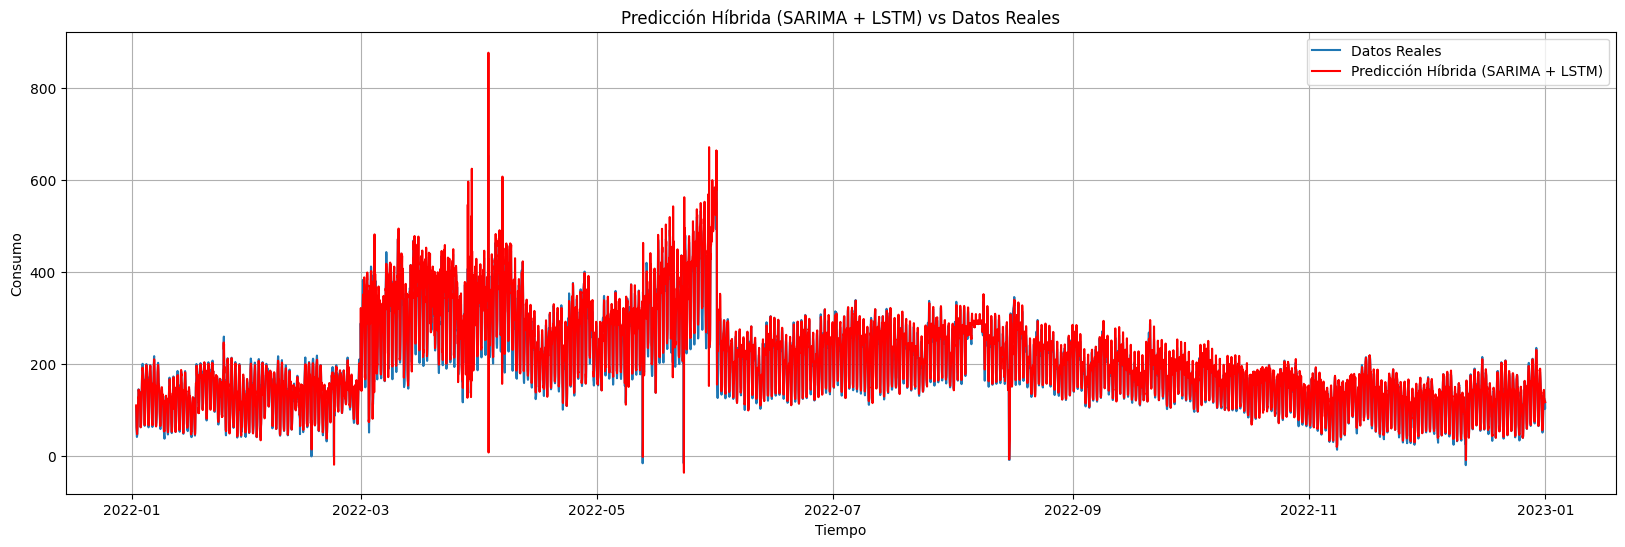

Mean Squared Error (MSE): 437.8757666690228
Root Mean Squared Error (RMSE): 20.92548127687922
Mean Absolute Error (MAE): 10.049837765353695
R-squared (R2): 0.9501729771130342


In [104]:

# — Graficar la Pronóstico híbrida frente a los Conjunto de datos reales
plt.figure(figsize=(20, 6))
plt.plot(data_test_substation[time_steps:], label='Datos Reales')
plt.plot(data_test_substation.index[time_steps:],final_pred_test[:], label='Predicción Híbrida (SARIMA + LSTM)', color='red')
plt.title('Predicción Híbrida (SARIMA + LSTM) vs Datos Reales')
plt.xlabel('Tiempo')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

# — Calcula las métricas
mse_SL = mean_squared_error(data_test_substation[time_steps:], final_pred_test)
rmse_SL = np.sqrt(mse_SL)
mae_SL = mean_absolute_error(data_test_substation[time_steps:], final_pred_test)
mape_SL = mean_absolute_percentage_error(data_test_substation[time_steps:], final_pred_test)
r2_SL = r2_score(data_test_substation[time_steps:], final_pred_test)

# — Imprime las métricas
print(f"Mean Squared Error (MSE): {mse_SL}")
print(f"Root Mean Squared Error (RMSE): {rmse_SL}")
print(f"Mean Absolute Error (MAE): {mae_SL}")
# — print(f"Mean Absolute Percentage Error (MAPE): {mape_SL}")
print(f"R-squared (R2): {r2_SL}")

### --- Metricas globales


In [265]:
metricas=pd.DataFrame()

In [ ]:
metricas['Metrica']=['MSE','RMSE','MAE','R2']
metricas['SARIMA_24']=[mse_sarima_24,rmse_sarima_24,mae_sarima_24,r2_sarima24]
metricas['SARIMA_exogen']=[mse,rmse, mae, r2]
metricas['LSTM']=[mse_LSTM,rmse_LSTM,mae_LSTM,r2_LSTM]
metricas['SARIMA_EX_LSTM']=[mse_SL,rmse_SL,mae_SL,r2_SL]

In [267]:
metricas

,Metrica,SARIMA_24,SARIMA_48,SARIMA_exogen,LSTM,SARIMA_EX_LSTM
0,MSE,11043.545975,10999.957693,8358.144164,935.356947,405.014403
1,RMSE,105.088277,104.880683,91.422886,30.583606,20.124970
2,MAE,77.139745,77.009602,62.694843,14.940660,9.889274
3,R2,-0.254888,-0.250005,0.050203,0.963165,0.953912
